In [1]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import os

In [2]:


pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

# Day1_Create the  population & employment data in MSA region111

## <font color='#F7DC6F '>Read Historical Delineation Files of the MSA regions</font>

In [3]:
msa_us = pd.read_excel('list1_2020.xls',dtype={'FIPS State Code': 'object', 'FIPS County Code': 'object', 'CBSA Code':'object', 'CSA Code':'object'},header=2)
msa_us = msa_us[msa_us['Metropolitan/Micropolitan Statistical Area'] == 'Metropolitan Statistical Area'].reset_index(drop=True)
msa_us['fips_couty'] = msa_us['FIPS State Code'] + msa_us['FIPS County Code']
msa_us = msa_us[['CBSA Code','CBSA Title','CSA Code','CSA Title','Metropolitan/Micropolitan Statistical Area','County/County Equivalent','fips_couty','Central/Outlying County']]

## <font color='#F7DC6F '>Read Geometry Data at Tract Level in U.S Mainland regions</font>

In [4]:
# import pandas as pd
# import geopandas as gpd

# tracts_us = pd.DataFrame()

# exclude_states = ['02', '15', '72', '78', '60', '66', '69', '74', '75', '79', '81', '84', '86', '87', '89', '71']

# for i in range(80):
#     state = str(i).zfill(2)
#     if state in exclude_states:
#         continue
#     try:
#         url = 'https://www2.census.gov/geo/tiger/TIGER2020/TRACT/tl_2020_'+state+'_tract.zip'
#         tracts = gpd.read_file(url)
#         tracts_us = pd.concat([tracts_us, tracts])
#         print(f"Processed state: {state}")
#     except Exception as e:
#         print(f"Error processing state {state}: {e}")
#         continue

# tracts_us.plot()

<Axes: >

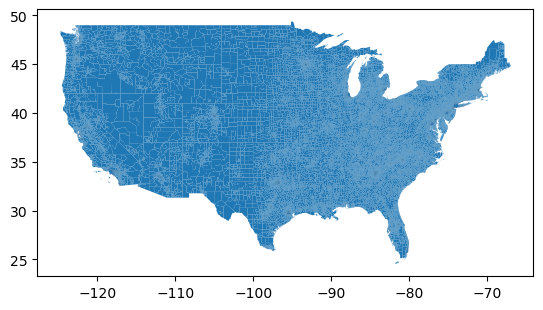

In [5]:
# read the API from the tiger line at Tract level
tracts_us = gpd.read_file('https://www2.census.gov/geo/tiger/GENZ2020/shp/cb_2020_us_tract_500k.zip')
# filter the outlines to only include the US states
exclude_states = ['02', '15', '72', '78', '60', '66', '69', '74', '75', '79', '81', '84', '86', '87', '89', '71']
tracts_us = tracts_us[~tracts_us['STATEFP'].isin(exclude_states)].reset_index(drop=True)
tracts_us['fips_couty'] = tracts_us['STATEFP'] + tracts_us['COUNTYFP']
tracts_us = tracts_us[['fips_couty','GEOID','NAMELSAD','STUSPS','STATE_NAME','NAMELSADCO','ALAND','geometry']]

tracts_us.plot()

## <font color='#F7DC6F '>Merge MSA data into Tract Geometry Data</font>

In [6]:
msa_us_merge = msa_us.merge(tracts_us, on='fips_couty', how='left')
msa_us_merge = msa_us_merge.dropna()

msa_us_merge = gpd.GeoDataFrame(msa_us_merge, geometry='geometry',crs=tracts_us.crs)

## <font color='#F7DC6F '>Read population and employment data by API </font>

In [7]:
# read the API key
import json
# import census API
from census import Census
from us import states

with open("census_api_key_Houpu.json", 'r') as f:
    key_file = f.read()
my_api_key = json.loads(key_file)['key']


def fetch_census_data(fields):
    """
    Fetches census data for the specified fields in 2020 for all counties and tracts across the U.S.

    Parameters:
    - api_key: str, Census API key.
    - fields: list of str, the specific columns to retrieve.
    """
    
    c = Census(my_api_key)
    data = c.acs5.state_county_tract(fields=fields,
                                        state_fips="*",  # Fetch the fips code across the us
                                        county_fips="*",  # fetch all the counties
                                        tract="*",  # fetch all the tracts
                                        year=2020)
    
    # transform the data into a DataFrame
    df = pd.DataFrame(data)
    
    # add a new columns to store the year
    df['year'] = 2020

    return df

In [8]:
import json
import pandas as pd
from census import Census
from us import states

# Read Census API key
with open("census_api_key_Houpu.json", 'r') as f:
    key_file = f.read()
my_api_key = json.loads(key_file)['key']

def fetch_census_data(fields):
    """
    Fetches census data for the specified fields in 2020 for all counties and tracts across the U.S.

    Parameters:
    - api_key: str, Census API key.
    - fields: list of str, the specific columns to retrieve.
    """
    
    c = Census(my_api_key)
    df = pd.DataFrame()
    
    for state in states.STATES:
        state_fips = state.fips
        data = c.acs5.state_county_tract(fields=fields,
                                         state_fips=state_fips,
                                         county_fips="*",  # fetch all the counties
                                         tract="*",  # fetch all the tracts
                                         year=2020)
        
        state_df = pd.DataFrame(data)
        df = pd.concat([df, state_df], ignore_index=True)
    
    df['year'] = 2020
    
    return df

In [9]:
fields = ['NAME', 'B01003_001E']  # B01003_001E:total population
pop_20 = fetch_census_data(fields)
pop_20 = pop_20.rename(columns={'B01003_001E':'tot_pop'})
pop_20['GEOID'] = pop_20['state'] + pop_20['county'] + pop_20['tract']

In [10]:
fields = ['NAME', 'B23001_001E']  # B23001_001:total employment for the 16 years old and over
emp_20 = fetch_census_data(fields)
emp_20 = emp_20.rename(columns={'B23001_001E':'tot_emp'})
emp_20['GEOID'] = emp_20['state'] + emp_20['county'] + emp_20['tract']

## <font color='#F7DC6F '>Integrate the data into MSA geomotry data</font>

In [11]:
msa_us_merge = msa_us_merge.merge(pop_20[['GEOID','tot_pop']], on='GEOID', how='left').merge(emp_20[['GEOID','tot_emp']], on='GEOID', how='left').dropna().reset_index(drop=True)

In [12]:
msa_us_merge.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 59954 entries, 0 to 59953
Data columns (total 17 columns):
 #   Column                                      Non-Null Count  Dtype   
---  ------                                      --------------  -----   
 0   CBSA Code                                   59954 non-null  object  
 1   CBSA Title                                  59954 non-null  object  
 2   CSA Code                                    59954 non-null  object  
 3   CSA Title                                   59954 non-null  object  
 4   Metropolitan/Micropolitan Statistical Area  59954 non-null  object  
 5   County/County Equivalent                    59954 non-null  object  
 6   fips_couty                                  59954 non-null  object  
 7   Central/Outlying County                     59954 non-null  object  
 8   GEOID                                       59954 non-null  object  
 9   NAMELSAD                                    59954 non-null  obje

<Axes: >

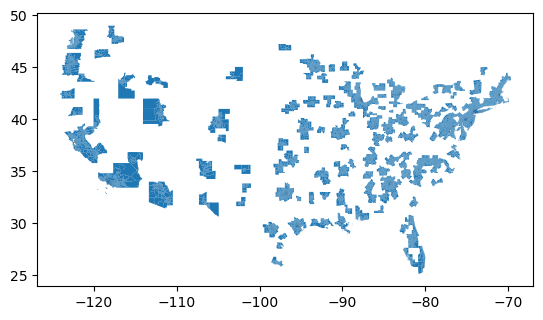

In [13]:
msa_us_merge.plot()

# Day2_Delineate the Polymetric and Monometric analysis by LISA and GWR